In [49]:
import torch
import json
import numpy as np
import pandas as pd

from models import UTAE
from dataset import RwandaFieldsTestSet

from utils.test_utils import *
from skimage.measure import label
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize,binary_dilation

import logging

In [59]:
def remove_boundary_positives(img,pixels=20):
    H,W = img.shape[-2:]
    bg = torch.zeros_like(img,dtype=img.dtype,device=img.device)

    s1 = min(pixels,H-1)
    e1 = max(s1+1,H-pixels) 
    s2 = min(pixels,W-1)
    e2 = max(s2+1,W-pixels) 
    
    bg[...,s1:e1,s2:e2] = img[...,s1:e1,s2:e2]
    return bg

def remove_boundary_positives_np(img,pixels=20):
    H,W = img.shape[:2]
    bg = np.zeros_like(img,dtype=img.dtype)

    s1 = min(pixels,H-1)
    e1 = max(s1+1,H-pixels) 
    s2 = min(pixels,W-1)
    e2 = max(s2+1,W-pixels) 
    bg[s1:e1,s2:e2,...] = img[s1:e1,s2:e2,...]
    return bg

In [2]:
#Best PREV SUBMISSION TILL NOW
"""
    './results_unet3d/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold0_V5',
    './results_unet3d/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold1_V5',
    './results_unet3d/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold0_V6',
    './results_unetpp3d/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold0_V5',
    './results_unetpp3d/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold1_V5',
"""
#Best SUBMISSION TILL NOW
"""
'./results_unet3d_new/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold0_V4',
    './results_unet3d_new/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold1_V4',
    './results_unet3d_new/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold2_V4',
    './results_unet3d_new/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold3_V4',
    './results_unetpp3d_new/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold0_V4',
    './results_unetpp3d_new/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold1_V4',
    './results_unetpp3d_new/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold2_V4',
    './results_unetpp3d_new/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold3_V4',
"""


"\n    './results_unet3d/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold0_V5',\n    './results_unet3d/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold1_V5',\n    './results_unet3d/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold0_V6',\n    './results_unetpp3d/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold0_V5',\n    './results_unetpp3d/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold1_V5',\n"

In [51]:
model_paths = [
    './results_unet3d_new/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold0_V4',
    './results_unet3d_new/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold1_V4',
    './results_unet3d_new/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold2_V4',
    './results_unet3d_new/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_100epochs_fold3_V4',
    './results_unetpp3d_new/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold0_V4',
    './results_unetpp3d_new/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold1_V4',
    './results_unetpp3d_new/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold2_V4',
    './results_unetpp3d_new/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold3_V4',


]

model_id = [model_path.split('/')[-1] for model_path in model_paths]

models,cfgs = [],[]
pos_encoding = []
for model_path in model_paths:
    model,cfg = load_trained_model(model_path,use_last_model=False)
    models.append(model)
    cfgs.append(cfg)
    print(cfg['padsize'],cfg['resize'])


320 None
320 None
320 None
320 None
320 None
320 None
320 None
320 None


In [52]:
def plot(imgs,y_pred,thresh=0.5):
    
    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)

    imgs = imgs[0].cpu()
    y_pred = y_pred[0,0].cpu().detach()

    fig,axs = plt.subplots(2,4,figsize = (40,20))
    B,C,H,W = imgs.shape
    for i in range(B):
        img = imgs[i,...].cpu().numpy()        
        img = img.transpose(1,2,0)
        row,col = i // 4, i%4
        
        img = img *2.5
        img = (img + 1)/ 2

        rgb = img[:,:,[2,1,0]]
        axs[row,col].imshow(rgb)

    axs[1,2].imshow(y_pred)
    axs[1,3].imshow(y_pred>thresh)
    
    logger.setLevel(old_level)

def remove_noise_from_mask(y_pred,thresh,remove_noise):
    if remove_noise > 0:
        pred_hard = (y_pred >= thresh).float().cpu().numpy()[0,0]
        
        washed = label(pred_hard>0,background=0,connectivity=2)
        washed = noise_filter(washed,mina=remove_noise)
        pred_hard = (washed > 0)[np.newaxis,np.newaxis,:,:]
        y_pred = torch.from_numpy(pred_hard).float().cuda()
    
    return y_pred


In [53]:
#temporary fix
data_cfg = cfgs[0]['dataset']
if 'resize' not in data_cfg.keys():
    data_cfg['resize'] = None
aug_tfm =  None if 'test_tfm' not in cfg.keys() else cfg['test_tfm']
dataset = RwandaFieldsTestSet(root=data_cfg['root'],months=data_cfg['months'],resize=data_cfg['resize'],aug_tfm=None)
#POS_ENCOD = cfgs[0]['model']['positional_encoding']

torch.Size([1, 1, 256, 256])


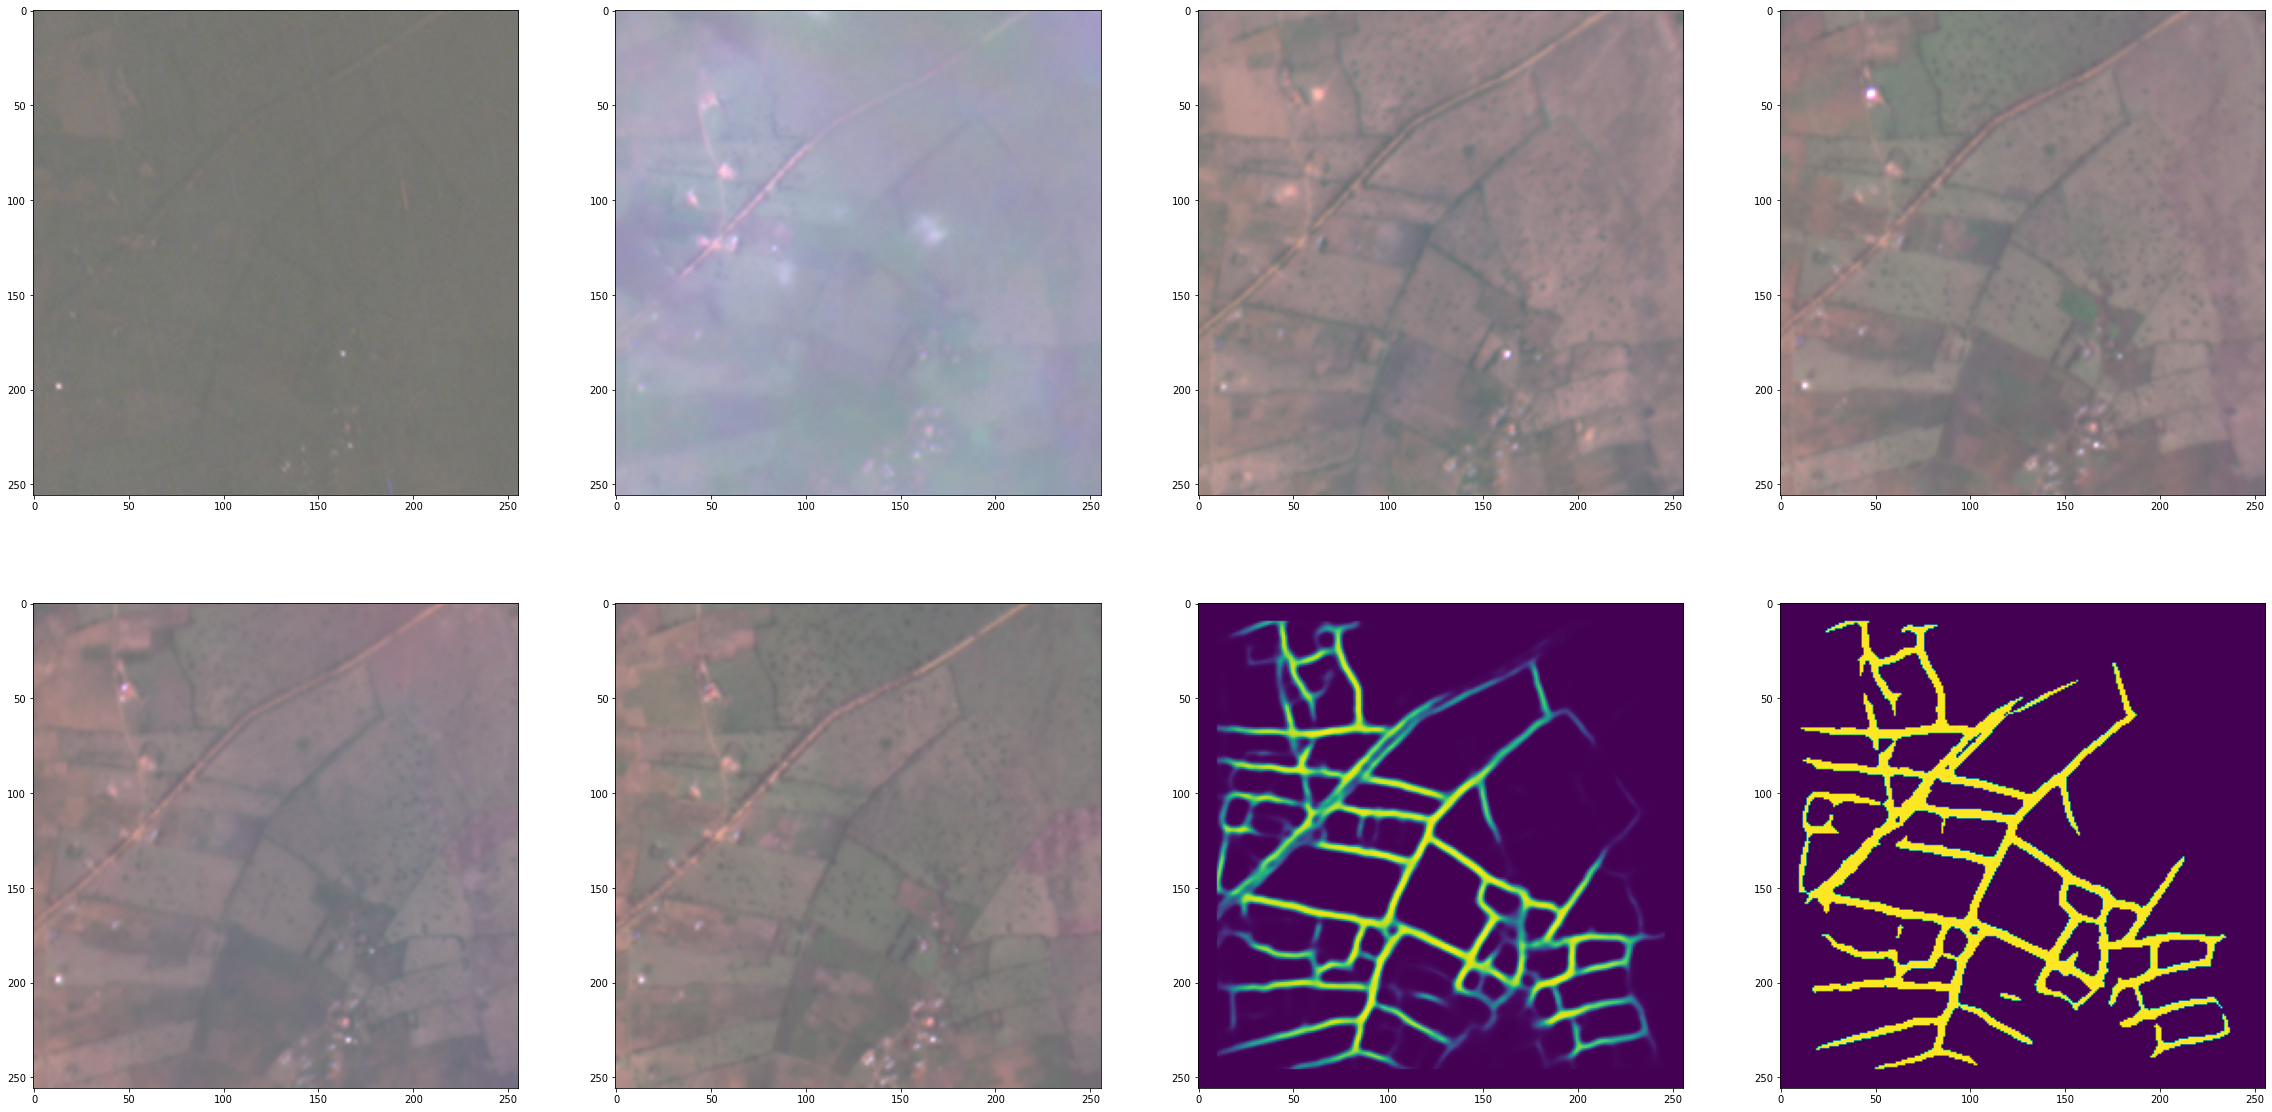

In [58]:
IDX = 0
TTA = True

remove_noise = 0
thresh = 0.5

RBP = 10

resize_sizes = [256]
pad_sizes = [320]

thresh = 0.3

ret = dataset.__getitem__(IDX)
imgs,dates,iid =ret['x'],ret['dates'],ret['iid']
tile_id = str(iid.split('_')[-1]).zfill(2)

imgs = imgs.unsqueeze(0)


preds = []
for model in models:
    model.cuda()
    
    for i in range(len(resize_sizes)):
        resize = resize_sizes[i]
        padsize = pad_sizes[i]
        
        x = imgs.clone().cuda()
        y_pred = run(x,model,padsize,resize,TTA)
        preds.append(y_pred)

    
    model.cpu()

if len(preds) > 1:
    y_pred = torch.cat(preds,dim=0)
    y_pred = y_pred.mean(dim=0).unsqueeze(0)

y_pred = remove_noise_from_mask(y_pred,thresh,remove_noise)

print(y_pred.shape)
if RBP > 0:
    y_pred = remove_boundary_positives(y_pred,pixels=RBP)
plot(imgs,y_pred,thresh)

plt.show()











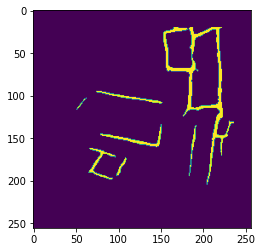

In [78]:
predictions_dictionary = {}

Thresh = 0.45
TTA = True
resize_sizes = [256]
pad_sizes = [320]#*3
RBP = 20
remove_noise = 20
cross = np.array([[0,1,0],[1,1,1],[0,1,0]])

for i in range(len(dataset)):
    ret = dataset.__getitem__(i)

    imgs,dates,iid =ret['x'],ret['dates'],ret['iid']
    tile_id = str(iid.split('_')[-1]).zfill(2)

    imgs = imgs.cuda().unsqueeze(0)
    dates = dates.cuda().unsqueeze(0)

    preds = []
    for model in models:
        model.cuda()
        for i in range(len(resize_sizes)):
            resize = resize_sizes[i]
            padsize = pad_sizes[i]
            
            x = imgs.clone().cuda()
            y_pred = run(x,model,padsize,resize,TTA)
            preds.append(y_pred)
        model.cpu()

    if len(preds) > 1:
        y_pred = torch.cat(preds,dim=0)
        y_pred = y_pred.mean(dim=0).unsqueeze(0)

    preds = torch.cat(preds,dim=0)

    y_pred = preds.mean(dim=0).unsqueeze(0)
    
    
    
    y_pred = y_pred[0,0,:,:].cpu().numpy()
    
    pred = y_pred >= Thresh
    #plt.imshow(pred)
    pred = pred.astype(np.uint8)

    if remove_noise > 0:
        washed = label(pred,background=0,connectivity=2)
        washed = noise_filter(washed,mina=remove_noise)
        pred = (washed > 0).astype(np.uint8)
        
    if RBP > 0:
        pred = remove_boundary_positives_np(pred,pixels=RBP)
        #print(y_pred.shape)
        plt.imshow(pred)

    predictions_dictionary.update([(str(tile_id), pd.DataFrame(pred))])

In [79]:
dfs = []
for key, value in predictions_dictionary.items():
    ftd = value.unstack().reset_index().rename(columns={'level_0': 'row', 'level_1': 'column', 0: 'label'})
    ftd['tile_row_column'] = f'Tile{key}_' + ftd['row'].astype(str) + '_' + ftd['column'].astype(str)
    ftd = ftd[['tile_row_column', 'label']]
    dfs.append(ftd)

sub = pd.concat(dfs)
sub

,tile_row_column,label
0,Tile00_0_0,0
1,Tile00_0_1,0
2,Tile00_0_2,0
3,Tile00_0_3,0
4,Tile00_0_4,0
...,...,...
65531,Tile12_255_251,0
65532,Tile12_255_252,0
65533,Tile12_255_253,0
65534,Tile12_255_254,0


In [80]:
sub['label'].value_counts()

0    791619
1     60349
Name: label, dtype: int64

In [39]:
if TTA:
    sub.to_csv(f'./submissions_new/{model_id[0]}_thresh{Thresh}_tta.csv', index = False)
else:
    sub.to_csv(f'./submissions_new/{model_id[0]}_thresh{Thresh}.csv', index = False)

In [81]:
if TTA:
    sub.to_csv(f'./submissions_ensemble/ensemblev14_thresh{Thresh}_tta_remnoise{remove_noise}_rembpix{RBP}.csv', index = False)
else:
    sub.to_csv(f'./submissions_ensemble/ensemblev14_thresh{Thresh}_remnoise{remove_noise}_rembpix{RBP}.csv', index = False)


In [11]:
sub.to_csv(f'./submissions_ensemble/ensemblev2_skeleton_thresh{Thresh}_tta_remnoise{remove_noise}.csv', index = False)

In [77]:
import pandas as pd
dddf = pd.read_csv('./submissions_ensemble/ensemblev14_thresh0.45_tta_remnoise20.csv')
dddf['label'].value_counts()

0    789059
1     62909
Name: label, dtype: int64